<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#BCS" data-toc-modified-id="BCS-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>BCS</a></span></li><li><span><a href="#Varying-Depth-size" data-toc-modified-id="Varying-Depth-size-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Varying Depth size</a></span></li><li><span><a href="#Plot-both-optimizers" data-toc-modified-id="Plot-both-optimizers-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Plot both optimizers</a></span></li></ul></div>

# BCS

Using the Paper by [Wu et al.](https://arxiv.org/abs/quant-ph/0108110), we have that:

The BCS hamiltonian is:

$$H_{BCS} = \sum_{m=1}^N \frac{\epsilon_m}{2} ( n_m^F + n_{-m}^F ) + \sum_{m,k=1}^N V^{+}_{ml} c^\dagger_m c^\dagger_{-m} c_{-l}c_l$$

Where $n_{\pm m}^F = c^\dagger_{\pm m} c_{\pm m}$, and the matrix elements $V^+_{ml} = \langle m, -m| V | l, -l \rangle$.

Which is mapped into:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m + \sum_{r= \pm l} \sum_{l>m=1}^N \frac{V_{ml}^r}{2} ( \sigma^x_m \sigma^x_l + r \sigma^y_m \sigma^y_l )$$

where $\epsilon_m = \epsilon_m + V^+_{mm}$ and $V^-_{ml} = 0$ for the BCS Hamiltonian, thus:

$$H_P = \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma^Z_m +  \sum_{l>m=1}^N \frac{V_{ml}}{2} ( \sigma^x_m \sigma^x_l +  \sigma^y_m \sigma^y_l )$$

$l \ \mathrm{and} \ m$ now denote both state and qubit indices. In this case the qubit state space $H_P = Span \{ |0 \rangle, \sigma^+_m |0 \rangle, \sigma_l^+ \sigma_m^+ |0 \rangle, \dots   \}$ is mapped into a subspace where $n_m^F = n^F_{-m}$. Considering $V_{ml} = V$, we have that:

$$
H_p = \hbar \bigg[ \sum_{m=1}^N \frac{\epsilon_m}{2} \sigma_z^m + \frac{V}{2} \sum_{l>m=1}^N (\sigma_x^m \sigma_x^l + \sigma_y^m \sigma_y^l) \bigg]
$$
[Aqua Operator Flow Reference](https://github.com/dongreenberg/aqua_talks/blob/master/Understanding%20Aqua's%20Operator%20Flow.ipynb)

In [1]:
import sys
sys.path.append('../../')

# Python imports
import numpy as np
import matplotlib.pyplot as plt

# Qiskit
from qiskit import BasicAer, Aer
from qiskit.aqua.components.optimizers import COBYLA, SPSA
from qiskit.circuit.library import TwoLocal

# VOLTA
from volta.vqd import VQD
from volta.utils import classical_solver
from volta.hamiltonians import BCS_hamiltonian

%load_ext autoreload
%autoreload 2

/home/nahum/anaconda3/lib/python3.6/site-packages/qiskit/__init__.py:67: DeprecationWarning: Using Qiskit with Python 3.6 is deprecated as of the 0.17.0 release. Support for running Qiskit with Python 3.6 will be removed in a future release.
  DeprecationWarning,
/home/nahum/anaconda3/lib/python3.6/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


In [3]:
EPSILONS = [3., 3.]
V = -2
hamiltonian = BCS_hamiltonian(EPSILONS, V)
print(hamiltonian)

SummedOp([
  1.5 * ZI,
  1.5 * IZ,
  -1.0 * XX,
  -1.0 * YY
])


In [4]:
eigenvalues, eigenvectors = classical_solver(hamiltonian)
print(f"Eigenvalues: {eigenvalues}")

Eigenvalues: [-3. -2.  2.  3.]


# Varying Depth size

In [5]:
from qiskit.providers.aer.noise import depolarizing_error
from qiskit.providers.aer.noise import thermal_relaxation_error
from qiskit.providers.aer.noise import NoiseModel

# Defining noise model

# T1 and T2 values for qubits 0-n
n_qubits = 2*len(EPSILONS)

# T1s = np.random.normal(50e3, 10e3, n_qubits) # Sampled from normal distribution mean 50 microsec
# T2s = np.random.normal(70e3, 10e3, n_qubits)  # Sampled from normal distribution mean 50 microsec

T1s = [30e3]*n_qubits
T2s = [20e3]*n_qubits

# Truncate random T2s <= T1s
T2s = np.array([min(T2s[j], 2 * T1s[j]) for j in range(n_qubits)])

# Instruction times (in nanoseconds)
time_u1 = 0   # virtual gate
time_u2 = 50  # (single X90 pulse)
time_u3 = 100 # (two X90 pulses)
time_cx = 300
time_reset = 1000  # 1 microsecond
time_measure = 1000 # 1 microsecond

# QuantumError objects
errors_reset = [thermal_relaxation_error(t1, t2, time_reset)
                for t1, t2 in zip(T1s, T2s)]
errors_measure = [thermal_relaxation_error(t1, t2, time_measure)
                  for t1, t2 in zip(T1s, T2s)]
errors_u1  = [thermal_relaxation_error(t1, t2, time_u1)
              for t1, t2 in zip(T1s, T2s)]
errors_u2  = [thermal_relaxation_error(t1, t2, time_u2)
              for t1, t2 in zip(T1s, T2s)]
errors_u3  = [thermal_relaxation_error(t1, t2, time_u3)
              for t1, t2 in zip(T1s, T2s)]
errors_cx = [[thermal_relaxation_error(t1a, t2a, time_cx).expand(
             thermal_relaxation_error(t1b, t2b, time_cx))
              for t1a, t2a in zip(T1s, T2s)]
               for t1b, t2b in zip(T1s, T2s)]

# Add errors to noise model
noise_thermal = NoiseModel()

for j in range(n_qubits):
    noise_thermal.add_quantum_error(errors_reset[j], "reset", [j])
    noise_thermal.add_quantum_error(errors_measure[j], "measure", [j])
    noise_thermal.add_quantum_error(errors_u1[j], "u1", [j])
    noise_thermal.add_quantum_error(errors_u2[j], "u2", [j])
    noise_thermal.add_quantum_error(errors_u3[j], "u3", [j])
    for k in range(n_qubits):
        noise_thermal.add_quantum_error(errors_cx[j][k], "cx", [j, k])

print(noise_thermal)

NoiseModel:
  Basis gates: ['cx', 'id', 'u2', 'u3']
  Instructions with noise: ['reset', 'measure', 'u3', 'u2', 'cx']
  Qubits with noise: [0, 1]
  Specific qubit errors: [('reset', [0]), ('reset', [1]), ('measure', [0]), ('measure', [1]), ('u2', [0]), ('u2', [1]), ('u3', [0]), ('u3', [1]), ('cx', [0, 0]), ('cx', [0, 1]), ('cx', [1, 0]), ('cx', [1, 1])]


In [ ]:
from tqdm import tqdm
from qiskit.aqua import QuantumInstance

# Parameters Variables
n_trials = 50
max_depth = 7

# Auxiliary Variables
solution_dict = {}

# Define Optimizer
#optimizer = COBYLA()
optimizer = SPSA(maxiter=250, c1=1.5, last_avg=25) 

# Define Backend
backend = QuantumInstance(backend= Aer.get_backend('qasm_simulator'),
                          noise_model=noise_thermal,
                          shots=10000)

for depth in range(1,max_depth):
    # Ansatz with diferent depth
    ansatz = TwoLocal(hamiltonian.num_qubits, ['ry','rz'], 'cx', reps=depth)
    es_1 = []
    es_2 = []
    
    for _ in tqdm(range(n_trials), desc=f"Depth {depth}"):

        # Run algorithm
        Algo = VQD(hamiltonian=hamiltonian,
                    ansatz=ansatz,
                    n_excited_states=2,
                    beta=10.,
                    optimizer=optimizer,
                    backend=backend)

        Algo.run(0)      
        vqd_energies = Algo.energies
        es_1.append(vqd_energies[1])
        es_2.append(vqd_energies[2])
    es_1 = np.array(es_1)
    es_2 = np.array(es_2)
    
    # Maybe use a pd.dataframe
    solution_dict[depth] = {'mean':np.mean(es_2 - es_1), 'std':np.std(es_2 - es_1)}

Depth 3:  84%|████████▍ | 42/50 [36:04:39<6:57:48, 3133.55s/it] 

In [ ]:
mean = []
std = []
for i in range(1,max_depth):
    mean.append(solution_dict[i]['mean'])
    std.append(solution_dict[i]['std'])

In [ ]:
solution_dict

In [ ]:
import seaborn as sns
sns.set()

In [ ]:
from matplotlib.ticker import MaxNLocator

x_axis = [i for i in range(1,max_depth)]
plt.errorbar(x_axis,
             np.array(mean)/2, 
             yerr=np.array(std)/2,
             fmt='ro', ecolor='green')

plt.hlines(y=2, xmin=0.5, xmax=6.5, 
           label='Expected value',color='b')
plt.title('Varying Depth', size=18)
plt.xlabel('Depth', size= 14)
plt.ylabel('Gap', size=14)
plt.xticks(x_axis)
plt.legend()
plt.show()

# Plot both optimizers

In [22]:
spsa_dict = {1: {'mean': 4.540763883482028, 'std': 0.2166500619449026},
 2: {'mean': 3.6292261939489365, 'std': 1.3793621699692478},
 3: {'mean': 3.5182758038620277, 'std': 0.8910628276050163},
 4: {'mean': 3.292976405037763, 'std': 1.3966224263108362},
 5: {'mean': 3.5144598497611055, 'std': 1.0963827019837287},
 6: {'mean': 2.6975338496665677, 'std': 1.3507496759669415}}


cobyla_dict = {1: {'mean': 2.3633300482974127, 'std': 2.1367566366817043},
 2: {'mean': 4.113586221793872, 'std': 0.7316145547992721},
 3: {'mean': 4.321305470168272, 'std': 0.4919574179280678},
 4: {'mean': 4.3014277420825975, 'std': 0.4023952320110141},
 5: {'mean': 4.157595644181709, 'std': 0.33724862839247316},
 6: {'mean': 3.968890438601869, 'std': 0.29850260762472425}}

mean_spsa = []
std_spsa = []
mean_cobyla = []
std_cobyla = []

for i in range(1,max_depth):
    mean_spsa.append(spsa_dict[i]['mean'])
    std_spsa.append(spsa_dict[i]['std'])
    mean_cobyla.append(cobyla_dict[i]['mean'])
    std_cobyla.append(cobyla_dict[i]['std'])

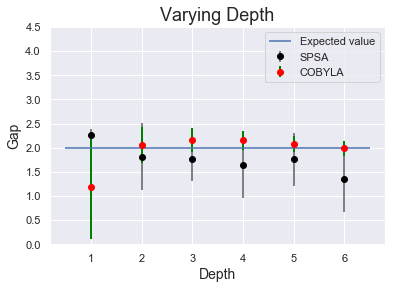

In [23]:
from matplotlib.ticker import MaxNLocator

x_axis = [i for i in range(1,max_depth)]

plt.errorbar(x_axis,
             np.array(mean_spsa)/2, 
             yerr=np.array(std_spsa)/2,
             fmt='o', color='black', 
             ecolor='gray', elinewidth=2,
             label='SPSA')

plt.errorbar(x_axis,
             np.array(mean_cobyla)/2, 
             yerr=np.array(std_cobyla)/2,
             fmt='o', color='red',
             ecolor='green', elinewidth=2,
             label='COBYLA')

plt.hlines(y=2, xmin=0.5, xmax=6.5, 
           label='Expected value',color='b')

plt.title('Varying Depth', size=18)
plt.xlabel('Depth', size= 14)
plt.ylabel('Gap', size=14)
plt.ylim(0., 4.5)
plt.xticks(x_axis)
plt.legend()
plt.savefig('Depth.png')
plt.show()